<a href="https://www.kaggle.com/code/ujjawalsingh10/skin-cancer-detection-using-cnn?scriptVersionId=134441096" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from glob import glob
from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print(os.listdir("../input/skin-cancer-mnist-ham10000"))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [3]:
#Matching the row info in HAM10000_metadata with corresponding images
img_dir = '../input/skin-cancer-mnist-ham10000'
image_path = glob(os.path.join(img_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_path}

In [4]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
### Returns categorical values and turns them into integer codes
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [9]:
df.shape

(10015, 10)

In [10]:
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Vascular lesions':5,
    'Melanoma':6,
}

## Data Cleaning

In [11]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [12]:
## We replace the null values with mean age
df['age'].fillna((df['age'].mean()), inplace = True)

### Visualizing the images

In [13]:
img_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

In [14]:
img_data.sample(10)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
3554,249,174,193,252,175,196,252,175,197,252,...,243,179,193,242,177,191,240,175,189,4
9627,183,147,154,185,151,158,187,153,157,186,...,185,159,163,185,160,166,183,160,166,4
6702,211,171,198,213,173,199,214,177,202,217,...,211,183,211,211,183,212,208,178,208,4
1151,86,58,51,127,98,100,147,112,101,150,...,93,59,50,44,22,23,13,3,2,3
5868,233,144,138,237,150,149,237,150,150,238,...,219,148,136,218,147,134,216,147,132,4
444,139,110,123,141,112,124,154,134,153,153,...,89,61,75,89,61,76,86,61,76,2
3095,214,131,136,217,130,135,220,132,139,220,...,210,137,125,208,138,129,204,131,120,4
7449,147,123,116,147,119,110,152,129,122,148,...,138,119,113,141,124,126,136,120,115,4
1806,130,110,125,160,144,159,167,149,163,176,...,115,94,110,42,29,41,10,5,9,6
7286,233,190,176,233,186,170,238,190,174,234,...,236,179,172,235,185,177,239,197,191,4


In [15]:
## Rescale the images
img_rescale = img_data/255

In [16]:
img_rescale.shape

(10015, 2353)

In [17]:
## Number of null values
img_rescale.isnull().sum()

pixel0000    0
pixel0001    0
pixel0002    0
pixel0003    0
pixel0004    0
            ..
pixel2348    0
pixel2349    0
pixel2350    0
pixel2351    0
label        0
Length: 2353, dtype: int64

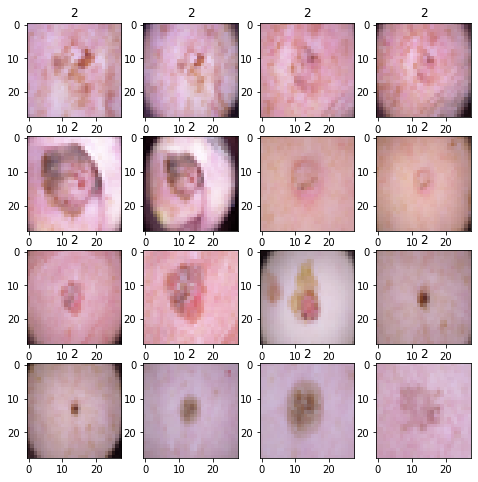

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(img_rescale.iloc[i, :2352].values.reshape(28,28,3))
    plt.title(img_data.iloc[i,2352])
    

In [19]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


### Resizing the image




In [20]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100))))

In [21]:


df['image'].map(lambda x: x.shape).value_counts()



(100, 100, 3)    10015
Name: image, dtype: int64

### Splitting the dataset

In [22]:
from tensorflow.keras.utils import to_categorical

features = df.drop(columns = ['cell_type_idx'], axis = 1)
label = df['cell_type_idx']

In [23]:
from sklearn.model_selection import train_test_split
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(features, label, test_size = 0.2)

### Normalization

In [24]:
x_train = np.asarray(X_train_data['image'].tolist())
x_test = np.asarray(X_test_data['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

X_train = (x_train - x_train_mean)/x_train_std
X_test = (x_test - x_test_mean)/x_test_std

In [25]:
X_train

array([[[[ 1.57715477,  0.244878  ,  0.58869136],
         [ 1.5986431 ,  0.244878  ,  0.63166803],
         [ 1.66310811,  0.30934301,  0.69613304],
         ...,
         [ 1.62013144,  0.41678468,  0.80357471],
         [ 1.5986431 ,  0.39529635,  0.76059804],
         [ 1.57715477,  0.30934301,  0.71762137]],

        [[ 1.5986431 ,  0.244878  ,  0.58869136],
         [ 1.57715477,  0.244878  ,  0.6101797 ],
         [ 1.57715477,  0.22338967,  0.63166803],
         ...,
         [ 1.64161977,  0.43827302,  0.84655138],
         [ 1.57715477,  0.35231968,  0.78208638],
         [ 1.51268976,  0.22338967,  0.69613304]],

        [[ 1.55566643,  0.244878  ,  0.54571469],
         [ 1.55566643,  0.22338967,  0.56720303],
         [ 1.51268976,  0.15892466,  0.52422636],
         ...,
         [ 1.5986431 ,  0.35231968,  0.80357471],
         [ 1.5986431 ,  0.35231968,  0.78208638],
         [ 1.49120143,  0.244878  ,  0.6746447 ]],

        ...,

        [[ 1.40524809,  0.33083134,  0

#### One hot encoding the labels

In [26]:

y_train = to_categorical(y_train_data, num_classes = 7)
y_test = to_categorical(y_test_data, num_classes = 7)


In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization

In [28]:
model = Sequential()
        
# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())

# [+] 5th convolutional layer
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 7th Dense layer
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 8th output layer
model.add(Dense(7, activation = 'softmax'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 384)         8

In [30]:
# model = Sequential()
# input_shape = (100, 100, 3)
# num_classes = 7
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

In [31]:
from tensorflow.keras.optimizers import Adam
EarlyStop = keras.callbacks.EarlyStopping(
               min_delta = 0.001,
               patience = 10 ,
               verbose = 0
)

optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None)

model.compile(
    optimizer =optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

### Splitting the training into validation set

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            learning_rate=0.00001)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

epochs = 50
batch_size = 32
#datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
#datagen.fit(X_train)

history = model.fit(X_train,y_train, epochs = epochs,
                    batch_size=batch_size,
                    callbacks = [EarlyStop, learning_rate_reduction],
                    validation_data = (X_valid, y_valid))

Epoch 1/50
226/226 [==============================] - 11s 15ms/step - loss: 1.3585 - accuracy: 0.6519 - val_loss: 0.9523 - val_accuracy: 0.7057
Epoch 2/50
226/226 [==============================] - 3s 12ms/step - loss: 0.9175 - accuracy: 0.6806 - val_loss: 0.9299 - val_accuracy: 0.6858
Epoch 3/50
226/226 [==============================] - 3s 12ms/step - loss: 0.8936 - accuracy: 0.6888 - val_loss: 0.8544 - val_accuracy: 0.7057
Epoch 4/50
226/226 [==============================] - 3s 12ms/step - loss: 0.8554 - accuracy: 0.6993 - val_loss: 1.1072 - val_accuracy: 0.7170
Epoch 5/50
226/226 [==============================] - 3s 12ms/step - loss: 0.8220 - accuracy: 0.7068 - val_loss: 0.7545 - val_accuracy: 0.7244
Epoch 6/50
226/226 [==============================] - 3s 12ms/step - loss: 0.8155 - accuracy: 0.7143 - val_loss: 0.8330 - val_accuracy: 0.7045
Epoch 7/50
226/226 [==============================] - 3s 12ms/step - loss: 0.7601 - accuracy: 0.7248 - val_loss: 0.8028 - val_accuracy: 0.733

### 

In [35]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

63/63 [==============================] - 0s 6ms/step - loss: 0.9562 - accuracy: 0.7249
Accuracy: 72.49%


### 

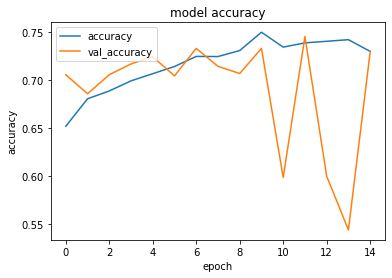

In [36]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()

